In [1]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure, draw, pause
import matplotlib.colors
from IPython.display import clear_output

In [2]:
def random_forest(width, height, vegetation_ratio=0.5, boulders=0, bouldersize=20):
    map_matrix = np.zeros((height, width))
    
    water = 0
    land = 1
    vegetation = 2
    
    for i in range(height):
        for j in range(width):
            
            # 2 tiles water padding
            if i < 2 or i > height - 3 or j < 2 or j > width - 3:
                map_matrix[i][j] = water

            # set initial vegetation
            elif random.random() < vegetation_ratio:
                map_matrix[i][j] = vegetation
            
            # set land
            else:
                map_matrix[i][j] = land
    
    for i in range(boulders):
        starting_point = [random.randint(0, height), random.randint(0, width)]
        
        for j in range(bouldersize):
            for k in range(bouldersize):
                map_matrix[(starting_point[0] + j) % height][(starting_point[1] + k) % width] = 1
        
    return map_matrix


def wind_matrix(degrees, multiplier=1):
    
    if multiplier < 0 or multiplier > 2:
        raise Exception('Please select a multiplier between 0 and 2 (inclusive).')

    degrees = degrees % 360
    
    n_diff = min(abs(360 - degrees), abs(360 - (degrees + 360))) / 180
    s_diff = min(abs(180 - degrees), abs(180 - (degrees + 360))) / 180
    w_diff = min(abs(270 - degrees), abs(270 - (degrees + 360))) / 180
    e_diff = min(abs(90 - degrees), abs(90 - (degrees + 360))) / 180
    
    nw_diff = min(abs(315 - degrees), abs(315 - (degrees + 360))) / 180
    ne_diff = min(abs(45 - degrees), abs(45 - (degrees + 360))) / 180
    sw_diff = min(abs(225 - degrees), abs(225 - (degrees + 360))) / 180
    se_diff = min(abs(135 - degrees), abs(135 - (degrees + 360))) / 180
    
    wind_matrix = np.zeros((3,3))
    wind_matrix[1, 1] = 1
    
    wind_matrix[0, 1] = 1 + (n_diff - .5) * multiplier
    wind_matrix[2, 1] = 1 + (s_diff - .5) * multiplier
    wind_matrix[1, 0] = 1 + (w_diff - .5) * multiplier
    wind_matrix[1, 2] = 1 + (e_diff - .5) * multiplier
    
    wind_matrix[0, 0] = 1 + (nw_diff - .5) * multiplier
    wind_matrix[0, 2] = 1 + (ne_diff - .5) * multiplier
    wind_matrix[2, 0] = 1 + (sw_diff - .5) * multiplier
    wind_matrix[2, 2] = 1 + (se_diff - .5) * multiplier
    
    return wind_matrix / (np.ones((3, 3)) * np.max(wind_matrix))

wind_matrix(135, 1)

array([[1.        , 0.83333333, 0.66666667],
       [0.83333333, 0.66666667, 0.5       ],
       [0.66666667, 0.5       , 0.33333333]])

In [43]:
class ForestFires:
    def __init__(self, map_matrix, init_burning_ratio, init_ratio_burned, wind_dir=0, wind_speed=0):
        self.map_matrix = map_matrix
        self.init_burning_ratio = init_burning_ratio
        self.init_ratio_burned = init_ratio_burned
        
        # relative coordinates of 3x3 neighbourhood kernel
        self.neigh_dirs = [[-1,-1], [-1,0], [-1,1], [0,-1], [0,0], [0,1], [1,-1], [1,0], [1,1]]

        # 3x3 kernels that influence the bruning_ratio of                                                             fire
        self.neigh_mult = np.array([[.833, 1, .833], [1, 1, 1], [.833, 1, .833]])
        self.wind_matrix = wind_matrix(wind_dir, wind_speed)  
        
        # init dictionary containing vegetation population
        self.veg_population = self.set_vegetation_population(self.map_matrix)
        
    def set_vegetation_population(self, map_matrix):
        veg_population = {}
        map_mat = map_matrix
        x_range = len(map_matrix[0])
        y_range = len(map_matrix)
        
        rand = random.random
        
        # iterate over grid
        for y in range(y_range):
            for x in range(x_range):
                
                # if vegetation
                if map_mat[y, x] == 2:
                    
                    # initial propability of vegetation burning
                    if rand() < self.init_burning_ratio:
                        veg_population[(x,y)] = Vegetation(self.init_ratio_burned, .5, 1)
                        
                    else:
                        veg_population[(x,y)] = Vegetation(0, 0, 1)
                    
        return veg_population

        
    def update(self):
        
        # create a temporary dict to safely replace values in the veg_population dict later on 
        temp_population = {}
        
        # 
        rand_matrix = np.random.rand
        sumof = np.sum
        zeros = np.zeros
        
        # assign class attributes to local variables for improved lookup speed
        current_population = self.veg_population.copy()
        map_matrix = self.map_matrix
        neigh_dirs = self.neigh_dirs
        neigh_mult = self.neigh_mult
        wind_matrix = self.wind_matrix
        
        for (x,y) in current_population:
            # if current vegetation is not burned up already
            if current_population[(x,y)].ratio_burned != 1:   
                
                # fill 3x3 neighbourhood kernel
                neigh_matrix = zeros((3,3))
                for (y_2, x_2) in neigh_dirs:
                    neigh_y = y + y_2
                    neigh_x = x + x_2

                    # add neighbour to kernel if it is vegetation
                    if map_matrix[neigh_y, neigh_x] == 2:
                        neigh_matrix[y_2 + 1, x_2 + 1] = current_population[(neigh_x, neigh_y)].ratio_burned
                        
                # calculate ratio_burned for current vegetation tile
                kernel = neigh_matrix * neigh_mult * wind_matrix
                
                # probability of a fire not counting towards burning rate of current vegetation
                kernel[kernel < rand_matrix(3,3)] = 0
                summed_matrix = sumof(kernel) 
                
                # determine the speed of the firespread by calculating the difference in ratio_burned
                delta_burned = abs(summed_matrix - current_population[(x,y)].ratio_burned)
                
                # add new ratio_burned state to temporary dict
                temp_population[(x,y)] = Vegetation((summed_matrix if summed_matrix < 1 else 1), delta_burned, 1)
                
        # update veg_population with new ratio_burned states
        for (x, y) in temp_population:
            current_population[(x,y)] = temp_population[(x,y)]
                
        self.veg_population = current_population.copy()
        
    def visualize(self, timestep, runtime):
        current_map = self.map_matrix.copy()
        current_population = self.veg_population.copy()
        
        # update burned_ratio with gradations if they are present in matrix
        fire_gradations = []  
        for (x,y) in current_population:
            p_burned = current_population[(x,y)].delta_burned
            if p_burned > 0:
                # start stage of fire
                if p_burned <= 0.33:
                    current_map[y][x] = 6
                    if 'yellow' not in fire_gradations:
                        fire_gradations.append('yellow')
                    
                # middle stage of fire
                elif p_burned > 0.33 and p_burned <= 0.66:
                    current_map[y][x] = 4
                    if 'orange' not in fire_gradations:
                        fire_gradations.append('orange')
                    
                # last stage of fire
                elif p_burned > 0.66 and p_burned < 1:
                    current_map[y][x] = 5
                    if 'red' not in fire_gradations:
                        fire_gradations.append('red')
                    
                # burned up
                else:
                    current_map[y][x] = 3
                    if 'black' not in fire_gradations:
                        fire_gradations.append('black')
                        
        # sort colors because of how matplotlib works...
        colors = ['blue', 'lightgrey', 'green']
        if fire_gradations:
            fire_gradations = sorted(fire_gradations)
            colors += fire_gradations    
            
        # plot current state of matrix
        figure(num=None, figsize=(10, 10))
        plt.title(f"Timestep = {timestep}\nFrame runtime = {runtime}")
        plt.imshow(current_map, cmap=matplotlib.colors.ListedColormap(colors))
        plt.show()
        clear_output(wait=True)
    
        
class Vegetation:
    def __init__(self, ratio_burned, delta_burned, height):
    
        # burning or neutral
        self.ratio_burned = ratio_burned
        self.height = height
        self.delta_burned = delta_burned

In [44]:
def forest_fire_simulation(iterations, height, width, 
                           vegetation_ratio=0.5, init_burning_ratio=0.05, init_ratio_burned=0.5, 
                           wind_dir=270, wind_speed=1):

    map_array = random_forest(width, height, vegetation_ratio=vegetation_ratio)
    
    forest_sim = ForestFires(map_array, init_burning_ratio=init_burning_ratio, init_ratio_burned=init_ratio_burned, 
                             wind_dir=wind_dir, wind_speed=wind_speed)

    iterations = iterations
    t = time.time
    prev_runtime = 0
    for i in range(iterations):
        t1 = t()
        forest_sim.visualize(i, prev_runtime)
        forest_sim.update()
        t2 = t()
        prev_runtime = t2-t1

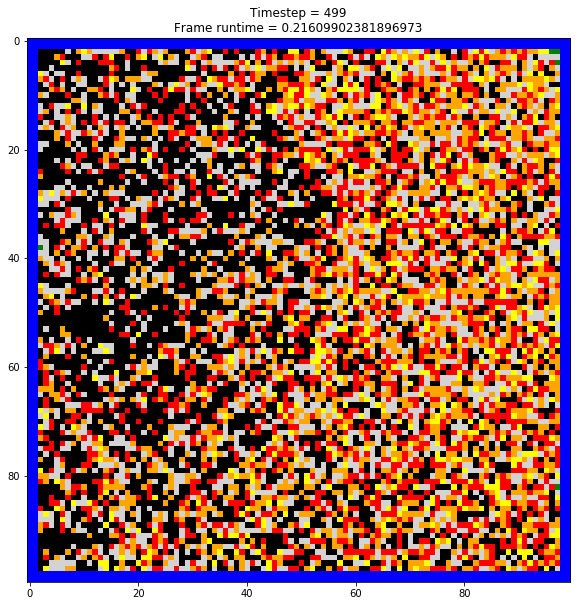

In [48]:
iterations = 500
width = 100
height = 100
vegetation_ratio = 0.8
init_burning_ratio = 0.005
init_ratio_burned = 0.5
wind_dir = 270
wind_speed = 1


forest_fire_simulation(iterations, height, width, 
                           vegetation_ratio, init_burning_ratio, init_ratio_burned, 
                           wind_dir, wind_speed)